This jupyter notebook is for my study on RBM for movie recommendation

This jupyter notebook is mainly based on Deep Learning with Pytorch 1.x (https://www.amazon.co.jp/Deep-Learning-PyTorch-1-x-architecture-ebook/dp/B07TB6SV6K) book.

Code ref: https://books.google.co.jp/books?id=h1jBDwAAQBAJ&pg=PA156&lpg=PA156&dq=wget+movielens+dataset&source=bl&ots=A0sx3MPnQa&sig=ACfU3U3O-SBXGD3CHPtwFmVlCJkkg2PDKQ&hl=ja&sa=X&ved=2ahUKEwjZ8ef4stXpAhVLxIsBHenNAxIQ6AEwBnoECAYQAQ#v=onepage&q=wget%20movielens%20dataset&f=false

https://github.com/luke4u/Restricted-Boltzmann-Machine-for-Movie-Review/blob/master/Boltzmann_Machine_Movie_Recommender.ipynb

https://github.com/paritoshshirodkar/Movie-Recommendation-System-Using-Restricted-Boltzmann-Machine/blob/master/pytorch/rbm.py

# Download MovieLens datasets

In [1]:
# MovieLens datasets: https://grouplens.org/datasets/movielens/
# Download and unzip
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o moviedataset.zip
!wget -O train_moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o train_moviedataset.zip

--2020-07-02 01:12:13--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>]   5.64M  14.8MB/s    in 0.4s    

2020-07-02 01:12:14 (14.8 MB/s) - ‘moviedataset.zip’ saved [5917549/5917549]

Archive:  moviedataset.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
--2020-07-02 01:12:17--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 492402

# Import modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn 
import torch.nn.parallel 
import torch.optim as optim 
import torch.utils.data 
from torch.autograd import Variable

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# load data to dataframe

In [3]:
movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python', encoding='latin-1')
users = pd.read_csv('ml-1m/users.dat', sep='::', header=None, engine='python', encoding='latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')

In [4]:
movies.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
users.head()

,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
# for checking file details
! cat ml-100k/README

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

## prepare training and testing datasets

In [8]:
# get training data and convert to array
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')

# get test data and convert to array
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

# check data shape
print (training_set.shape)
print (test_set.shape)

(79999, 4)
(19999, 4)


In [9]:
# get max numbers of users and movies of train and test datasets
nb_users = int(max(max(training_set[:, 0]), max(test_set[:, 0])))
nb_movies =  int(max(max(training_set[:, 1]), max(test_set[:, 1])))
print ("number of users: ", nb_users)
print ("number of movies: ", nb_movies)

number of users:  943
number of movies:  1682


In [10]:
# convert data to matrix
def convert_dataset(data):
    converted_data = []
    for id_users in range(1, nb_users + 1):
        ##id of movies that is rated by current users
        id_movies = data[:,1][data[:,0] == id_users]
        
        ##rate of movies that is given by current user
        id_ratings = data[:,2][data[:,0] == id_users]
        
        #inialize ratings for all movies
        #set 0 for movies that are not rated by current users
        ratings = np.zeros(nb_movies)
        #movie id starts from 1, 1st movie will be 1st element in rating with index as 0
        ratings[id_movies - 1] = id_ratings
        converted_data.append(list(ratings))
    return converted_data

In [11]:
# convert data to matrix
training_set = convert_dataset(training_set)
test_set = convert_dataset(test_set)

In [12]:
# convert data into Torch tensor
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

In [13]:
# convert data into binary for binary classification
## convert rating 1-5 to binary 1 or 0, as the target is to predict like or not
## so this is to make input and output data consistent
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1

test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

print (training_set.shape)
print (test_set.shape)

torch.Size([943, 1682])
torch.Size([943, 1682])


## visualise processed data

Text(0.5, 0.98, 'Rating: -1=no data, 0=low rating, 1=high rating')

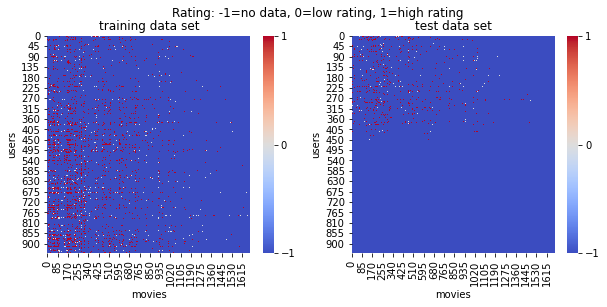

In [14]:
# visualise training and test rating data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(training_set, cmap="coolwarm", cbar_kws={"ticks":np.arange(-1,2)}, ax=ax1)
ax1.set_xlabel('movies')
ax1.set_ylabel('users')
ax1.set_title("training data set")
sns.heatmap(test_set, cmap="coolwarm", cbar_kws={"ticks":np.arange(-1,2)}, ax=ax2)
ax2.set_xlabel('movies')
ax2.set_ylabel('users')
ax2.set_title("test data set")
plt.suptitle("Rating: -1=no data, 0=low rating, 1=high rating")

# Restricted Boltzmann Machines (RBM)

## RBM Model

In [15]:
class RBM():
    def __init__(self, num_visible_nodes, num_hidden_nodes):
        ##initialize all weights 
        ##a tensor with size of num_hidden_nodes, num_visible_nodes in normal dis mean 0 var 1
        self.W = torch.randn(num_hidden_nodes, num_visible_nodes)
        self.a = torch.randn(1, num_hidden_nodes)  #bias for hidden nodes - #1st dimension is batch, 2nd is num of hidden nodes
        self.b = torch.randn(1, num_visible_nodes) #bias for visible nodes
        
    #activate the hidden nodes by sampling all hiddens node, given values of visible nodes 
    def sample_hidden_nodes(self, x):
        #x is values of visible nodes
        #probablity of hiddens h to be activated, given values of visible  nodes v
        wx = torch.mm(x, self.W.t())
        #use sigmoid fuc to activate visible node
        ## a is bias for hidden nodes
        activation = wx + self.a.expand_as(wx)
        ##ith of the vector is the probability of ith hidden nodes to be activated, 
        ##given visible values
        p_h_given_v =torch.sigmoid(activation)
        #samples of all hiddens nodes
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_visible_nodes(self, y):
        #y is hidden nodes
        #probablity of visible h to be activated, given hidden  nodes v
        wy = torch.mm(y, self.W)
        #use sigmoid fuc to activate hiddens nodes
        activation = wy + self.b.expand_as(wy)
        ##ith of the vector is the probability of ith visible nodes to be activated, 
        ##given hidden values
        p_v_given_h =torch.sigmoid(activation)
        #samples of all hiddens nodes
        return p_v_given_h, torch.bernoulli(p_v_given_h)
        
    #visible nodes after kth interation
    #probablity of hidden nodes after kth iteration
    def train(self, v0, vk, ph0, phk):
        # self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        #add zero to keep b as a tensor of 2 dimension
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)
    
    # for prediction, input pass hidden nodes and reconstruct back to visible nodes
    def predict(self, x): # x is visible nodes
        _, h = self.sample_hidden_nodes(x)
        _, v = self.sample_visible_nodes(h)
        return v

## set up parameters and call RBM model

In [16]:
# define model parameters
num_visible_nodes = len(training_set[0]) #number of movies
num_hidden_nodes = 100 #number of hidden nodes or num of features
batch_size = 100

# call RBM model
rbm = RBM(num_visible_nodes, num_hidden_nodes)

## train RBM model

In [17]:
##train the RBM
nb_epoch = 10
train_loss_list = []
for epoch in range(1, nb_epoch+1):
    ##loss function
    train_loss = 0
    #normalize the loss, define a counter
    s = 0.
    #implement a batch learning, 
    for id_user in range(0, nb_users - batch_size, 100):
        #input batch values
        vk = training_set[id_user: id_user+batch_size]
        #target used for loss mesarue: rating 
        v0 = training_set[id_user: id_user+batch_size]
        ##initilize probablity
        #pho: given real rating at begining, probablity of hidden nodes
        ph0, _ = rbm.sample_hidden_nodes(v0)
        #k step of constrative divergence
        for k in range(10):
            _, hk = rbm.sample_hidden_nodes(vk)
            _, vk = rbm.sample_visible_nodes(hk)
            #training on rating that do exist, rating as -1
            vk[v0<0] = v0[v0<0]
        phk, _ = rbm.sample_hidden_nodes(vk)
        #update weights and bias
        rbm.train(v0, vk, ph0, phk)
        #update train loss
        train_loss += torch.mean(torch.abs(v0[v0>0]-vk[v0>0]))
        s += 1
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))
    train_loss_list.append ( train_loss )

epoch: 1 loss: tensor(0.2965)
epoch: 2 loss: tensor(0.1458)
epoch: 3 loss: tensor(0.1555)
epoch: 4 loss: tensor(0.1457)
epoch: 5 loss: tensor(0.1527)
epoch: 6 loss: tensor(0.1466)
epoch: 7 loss: tensor(0.1506)
epoch: 8 loss: tensor(0.1527)
epoch: 9 loss: tensor(0.1447)
epoch: 10 loss: tensor(0.1492)


Text(0.5, 1.0, 'training')

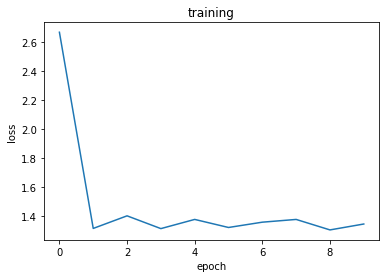

In [18]:
# plot loss
plt.plot(train_loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("training")

# test RBM model

In [19]:
##loss function
test_loss = 0
#normalize the loss, define a counter
s = 0.
#implement a batch learning, 
predicted_v_input = []
test_input = []
for id_user in range(0, nb_users):
    #use input of train set to activate RBM
    v_input = training_set[id_user: id_user+1]
    #target used for loss mesarue: rating 
    v_target = test_set[id_user: id_user+1]
    #use only 1 step to make better prediction, though used 10 steps to train
    if len(v_target[v_target>=0]):
        # predict data 
        v_input = rbm.predict(v_input)
        #update test loss
        test_loss += torch.mean(torch.abs(v_target[v_target>0]-v_input[v_target>0]))
        predicted_v_input.append ( v_input.detach().numpy()[0] )
        test_input.append ( v_target.detach().numpy()[0] )
        s += 1
predicted_v_input = np.array(predicted_v_input)
print('test loss: ' +str(test_loss/s))

test loss: tensor(0.1658)


## visualise test data

Text(0.5, 0.98, 'Rating: -1=no data, 0=low rating, 1=high rating')

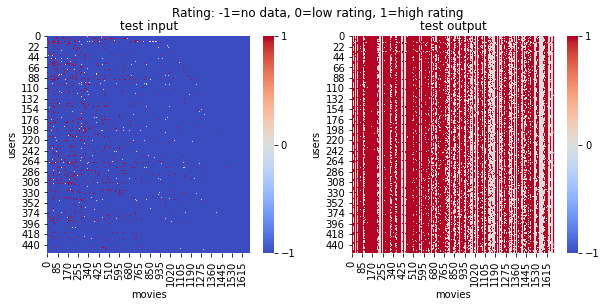

In [20]:
# visualise test input and output rating data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(test_input, cmap="coolwarm", vmin=-1, cbar_kws={"ticks":np.arange(-1,2)}, ax=ax1)
ax1.set_xlabel('movies')
ax1.set_ylabel('users')
ax1.set_title("test input")
sns.heatmap(predicted_v_input, cmap="coolwarm", vmin=-1,  cbar_kws={"ticks":np.arange(-1,2)}, ax=ax2)
ax2.set_xlabel('movies')
ax2.set_ylabel('users')
ax2.set_title("test output")
plt.suptitle("Rating: -1=no data, 0=low rating, 1=high rating")

## check accuracy of available test data

In [21]:
# select tested dataframe comparing predicted and original data
df_test = pd.DataFrame({'predict': np.concatenate(predicted_v_input), 
                        'original': np.concatenate(test_input)})

# select only data that original data is available
df_select = df_test[df_test["original"] != -1.0]
print ("number of predicted data", len(df_test))
print ("number of original data", len(df_select))

number of predicted data 772038
number of original data 19999


In [22]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, title):
    # get_metrics
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

    # confusion matrix
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm_labeled, annot=True, cmap='Greens', fmt='g')
    plt.xlabel("predict")
    plt.ylabel("actual")
    plt.title(title)
    return

Accuracy: 0.7443372168608431
Precision: 0.7515540484429704
Recall: 0.7443372168608431
F1 Score: 0.7478304193100346


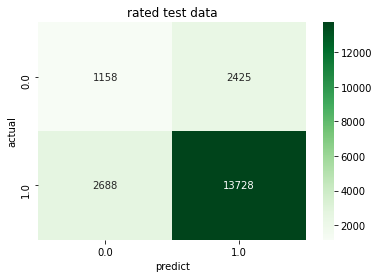

In [23]:
# check accuracy of test data comparing to rating available test data
true_labels = df_select["original"]
predicted_labels = df_select["predict"]
plot_confusion_matrix(true_labels, predicted_labels, "rated test data")